## Importing Libraries

Tested on a virtual environment running Python version 3.12.8

In [1]:
!pip install pandas -q
!pip install wheel -q
!pip install ipywidgets -q
!pip install setuptools -q
!pip install xgboost -q
!pip install catboost -q
!pip install -U scikit-learn -q
!pip install matplotlib -q
!pip install seaborn -q
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from datetime import datetime
import matplotlib.pyplot as plt
from math import log
import numpy as np
import seaborn as sns


## Time to Load the dataset

In [3]:
rent_df = pd.read_csv('/Users/utkarsh/Desktop/Utkarsh/NYU/Year 2/Semester 1/DS/Project/rent-raja/final_data_cleaning/final_cleaned_data.csv')
rent_df.head()

,Unnamed: 0,listedAt,daysOnMarket,availableFrom,street,price,borough,neighborhood,zip,propertyType,...,Hispanic or Latino_ratio,Population Below Poverty Level_ratio,Employed_ratio,Unemployed_ratio,High School Graduate (Age 25+)_ratio,Bachelor’s Degree (Age 25+)_ratio,Graduate or Professional Degree (Age 25+)_ratio,Never Married_ratio,Currently Married_ratio,Divorced_ratio
0,0,2024-11-25,1.0,2024-11-25,171 East 96th Street #4A,1855.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
1,1,2024-11-22,4.0,2024-11-22,93 East 96th Street #11,2235.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
2,2,2024-11-22,4.0,2024-11-22,501 Saratoga Avenue #B,1750.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
3,3,2024-11-20,6.0,2024-11-20,1115 Willmohr Street #2P,1850.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
4,4,2024-11-19,7.0,2024-11-19,1075 Clarkson Avenue #2B,3000.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939


In [4]:
rent_df.drop(columns=['Unnamed: 0'], inplace=True)
rent_df.head()

,listedAt,daysOnMarket,availableFrom,street,price,borough,neighborhood,zip,propertyType,beds,...,Hispanic or Latino_ratio,Population Below Poverty Level_ratio,Employed_ratio,Unemployed_ratio,High School Graduate (Age 25+)_ratio,Bachelor’s Degree (Age 25+)_ratio,Graduate or Professional Degree (Age 25+)_ratio,Never Married_ratio,Currently Married_ratio,Divorced_ratio
0,2024-11-25,1.0,2024-11-25,171 East 96th Street #4A,1855.0,Brooklyn,brownsville,11212,rental,1,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
1,2024-11-22,4.0,2024-11-22,93 East 96th Street #11,2235.0,Brooklyn,brownsville,11212,rental,2,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
2,2024-11-22,4.0,2024-11-22,501 Saratoga Avenue #B,1750.0,Brooklyn,brownsville,11212,rental,1,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
3,2024-11-20,6.0,2024-11-20,1115 Willmohr Street #2P,1850.0,Brooklyn,brownsville,11212,rental,1,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
4,2024-11-19,7.0,2024-11-19,1075 Clarkson Avenue #2B,3000.0,Brooklyn,brownsville,11212,rental,3,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939


## Convert rent variable into a cateogrical variable

In [5]:

num_buckets = 8  

# Create quantile-based buckets with integer labels
rent_df['rent_bucket'] = pd.qcut(rent_df['price'], q=num_buckets, labels=[i for i in range(1, num_buckets+1)])

# Display the bins and distribution
bin_edges = pd.qcut(rent_df['price'], q=num_buckets, retbins=True)[1]
distribution = rent_df['rent_bucket'].value_counts(normalize=True, sort=False)

label_to_range: dict[int, str] = {i: f"${bin_edges[i]:,.2f} - ${bin_edges[i+1]:,.2f}" for i in range(len(bin_edges) - 1)}

for i in range(len(bin_edges) - 1):
    print(f"Bucket {i+1}: ${bin_edges[i]:,.2f} - ${bin_edges[i+1]:,.2f} with {round(distribution.iloc[i]*100, ndigits=2)}% of data")

Bucket 1: $1,199.00 - $2,250.00 with 13.13% of data
Bucket 2: $2,250.00 - $2,625.00 with 11.95% of data
Bucket 3: $2,625.00 - $2,950.00 with 12.89% of data
Bucket 4: $2,950.00 - $3,250.00 with 12.59% of data
Bucket 5: $3,250.00 - $3,650.00 with 12.04% of data
Bucket 6: $3,650.00 - $4,295.00 with 12.47% of data
Bucket 7: $4,295.00 - $6,000.00 with 12.52% of data
Bucket 8: $6,000.00 - $125,000.00 with 12.41% of data


In [6]:
rent_df.head()

,listedAt,daysOnMarket,availableFrom,street,price,borough,neighborhood,zip,propertyType,beds,...,Population Below Poverty Level_ratio,Employed_ratio,Unemployed_ratio,High School Graduate (Age 25+)_ratio,Bachelor’s Degree (Age 25+)_ratio,Graduate or Professional Degree (Age 25+)_ratio,Never Married_ratio,Currently Married_ratio,Divorced_ratio,rent_bucket
0,2024-11-25,1.0,2024-11-25,171 East 96th Street #4A,1855.0,Brooklyn,brownsville,11212,rental,1,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1
1,2024-11-22,4.0,2024-11-22,93 East 96th Street #11,2235.0,Brooklyn,brownsville,11212,rental,2,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1
2,2024-11-22,4.0,2024-11-22,501 Saratoga Avenue #B,1750.0,Brooklyn,brownsville,11212,rental,1,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1
3,2024-11-20,6.0,2024-11-20,1115 Willmohr Street #2P,1850.0,Brooklyn,brownsville,11212,rental,1,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1
4,2024-11-19,7.0,2024-11-19,1075 Clarkson Avenue #2B,3000.0,Brooklyn,brownsville,11212,rental,3,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,4


## Looking at the Dataframe

At some points, there was no census data available, so we drop those rows here.

In [7]:
nan_summary = rent_df.isnull().sum().to_frame(name='NaN Count')
nan_summary['Percentage'] = (nan_summary['NaN Count'] / len(rent_df)) * 100
nan_summary

,NaN Count,Percentage
listedAt,5052,64.422341
daysOnMarket,1239,15.799541
availableFrom,1463,18.655955
street,0,0.000000
price,0,0.000000
borough,0,0.000000
neighborhood,5052,64.422341
zip,0,0.000000
propertyType,0,0.000000
beds,0,0.000000


In [8]:
rent_df_cleaned = rent_df.dropna(subset=['Employed_ratio'])

### NEighbourhood is empty

time to fill it up

In [9]:
default_datetime = datetime(2024, 11, 28, 0, 0, 0)
def calculate_date_delta(row):
    available_date = pd.to_datetime(row['availableFrom'])
    return (available_date - default_datetime).days

### Other stuff

We delete listedAt because daysOnMarket kind of captures that nuance.

In [10]:
mean_days_on_market = rent_df['daysOnMarket'].mean()
rent_df_cleaned['daysOnMarket'] = rent_df_cleaned['daysOnMarket'].fillna(mean_days_on_market)

rent_df_cleaned['neighborhood'] = rent_df_cleaned['neighborhood'].fillna(rent_df_cleaned['borough'])

rent_df_cleaned['isStreetEasy'] = rent_df_cleaned['amenities'].notnull()

rent_df_cleaned['availableFrom'] = rent_df_cleaned['availableFrom'].fillna(default_datetime)
rent_df_cleaned['availableFrom'] = rent_df_cleaned.apply(calculate_date_delta, axis=1)

rent_df_cleaned.drop(columns=['listedAt', 'amenities', 'builtIn', 'description'], inplace=True)

print(f"Original dataset shape: {rent_df.shape}")
print(f"Cleaned dataset shape: {rent_df_cleaned.shape}")

nan_summary = rent_df_cleaned.isnull().sum().to_frame(name='NaN Count')
nan_summary['Percentage'] = (nan_summary['NaN Count'] / len(rent_df)) * 100
nan_summary

rent_df_cleaned

/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_18936/4033777650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['daysOnMarket'] = rent_df_cleaned['daysOnMarket'].fillna(mean_days_on_market)
/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_18936/4033777650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['neighborhood'] = rent_df_cleaned['neighborhood'].fillna(rent_df_cleaned['borough'])
/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_18

Original dataset shape: (7842, 50)
Cleaned dataset shape: (6971, 47)


/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_18936/4033777650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['availableFrom'] = rent_df_cleaned.apply(calculate_date_delta, axis=1)
/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_18936/4033777650.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned.drop(columns=['listedAt', 'amenities', 'builtIn', 'description'], inplace=True)


,daysOnMarket,availableFrom,street,price,borough,neighborhood,zip,propertyType,beds,baths,...,Employed_ratio,Unemployed_ratio,High School Graduate (Age 25+)_ratio,Bachelor’s Degree (Age 25+)_ratio,Graduate or Professional Degree (Age 25+)_ratio,Never Married_ratio,Currently Married_ratio,Divorced_ratio,rent_bucket,isStreetEasy
0,1.000000,-3,171 East 96th Street #4A,1855.0,Brooklyn,brownsville,11212,rental,1,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1,True
1,4.000000,-6,93 East 96th Street #11,2235.0,Brooklyn,brownsville,11212,rental,2,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1,True
2,4.000000,-6,501 Saratoga Avenue #B,1750.0,Brooklyn,brownsville,11212,rental,1,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1,True
3,6.000000,-8,1115 Willmohr Street #2P,1850.0,Brooklyn,brownsville,11212,rental,1,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1,True
4,7.000000,-9,1075 Clarkson Avenue #2B,3000.0,Brooklyn,brownsville,11212,rental,3,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7830,121.000000,0,1027 Faile St APT 3,4070.0,Bronx,Bronx,10459,apartment,4,1.0,...,0.398834,0.064545,0.133881,0.064083,0.000866,0.207451,0.126357,0.028654,6,False
7831,6.000000,-10,80 Tyrrell St #1,3800.0,Staten Island,Staten Island,10307,apartment,3,3.0,...,0.468655,0.004066,0.140969,0.136089,0.003321,0.148153,0.242765,0.031040,6,False
7839,5.000000,-10,11 Maiden Ln APT 6B,3750.0,Manhattan,Manhattan,10038,apartment,2,1.0,...,0.538791,0.028702,0.060532,0.279527,0.011095,0.239472,0.145440,0.017179,6,False
7840,22.006664,0,88 Fulton St #TOWNHOUSE 1,3200.0,Manhattan,Manhattan,10038,apartment,1,1.0,...,0.538791,0.028702,0.060532,0.279527,0.011095,0.239472,0.145440,0.017179,4,False


## Time to split our dataset

In [11]:
X = rent_df_cleaned.drop(columns=['price', 'rent_bucket'])
y = rent_df_cleaned['rent_bucket']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### CatBoost

We start experimenting with training using Catboost because it doesn't need any categorical data to be encoded in any way or form. 

In [12]:
cat_features = [
    'street',
    'borough',
    'propertyType',
    'neighborhood'
]

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 2],
    'border_count': [32, 64, 128],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'boosting_type': ['Ordered', 'Plain']
}


In [ ]:
# Initialize and train CatBoost
model = CatBoostClassifier(cat_features=cat_features)
grid_search_result = model.grid_search(param_grid, X=X_train, y=y_train, plot=True)

# Make predictions
y_pred = model.predict(X_test)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="1711 Avenue V FLOOR 2": Cannot convert 'b'1711 Avenue V FLOOR 2'' to float

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.41


## ROC-AUC Time

In [ ]:
# Get predicted probabilities for all classes
y_pred_proba = model.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
# Converts y_test to a binary matrix of shape (n_samples, n_classes)
y_test_binarized = label_binarize(y_test, classes=[x+1 for x in range(num_buckets)])  # Adjust classes as per your dataset

# Compute the multi-class ROC AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovo")  # "ovo" is another option
print(f"Multi-Class ROC AUC Score: {roc_auc:.4f}")

Multi-Class ROC AUC Score: 0.8316


## Confusion Matrix Time

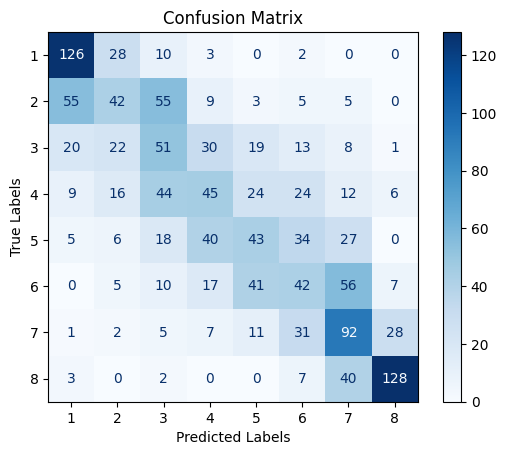

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

# Beautify the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Interesting Observation

We notice That our model gets the class right or predicts the class right next to it so we think it would be interesting to come up with a relaxed accuracy metric, which will think that the predicted class is correct if it is Numeric adjacent to the correct class

In [ ]:
def relaxed_accuracy(y_true, y_pred):
    """
    Calculates accuracy with ±1 tolerance for class predictions.
    
    Parameters:
    y_true (array-like): True class labels.
    y_pred (array-like): Predicted class labels.
    
    Returns:
    float: Relaxed accuracy score.
    """
    # Count correct predictions with ±1 tolerance
    correct = sum(abs(true - pred) <= 1 for true, pred in zip(y_true, y_pred))
    
    # Calculate accuracy
    accuracy = correct / len(y_true)
    
    return accuracy

accuracy = relaxed_accuracy(y_test, y_pred)
print(f"Relaxed Accuracy (±1): {accuracy[0]:.2f}")


Relaxed Accuracy (±1): 0.79


## Weighted Relaxed Accuracy

It's not fair to weight being one class off the true class. So here we propose (casually) a generic function that gives a weighted relaxed accuracy. It wieghts accoridngly 
1. 	Distance Sensitivity:
Classes that are further apart in index (e.g., true class = 5, predicted class = 7) incur a greater penalty than classes that are closer (e.g., predicted = 4 or 6).
2. Range Sensitivity:
Predictions that are off by a class whose range is large are penalized more than predictions off by a class with a smaller range. For instance, guessing a bucket spanning 1000 units is considered a larger error than guessing one spanning 200 units.

In [ ]:
bucket_ranges: dict[int, float] = {i: bin_edges[i+1] - bin_edges[i] for i in range(num_buckets)}

max_range = sum(bucket_ranges.values())
normalized_bucket_ranges = {k+1: (log(v + 1, 1.4) / log(max_range + 1, 20))/10 for k, v in bucket_ranges.items()}

print(normalized_bucket_ranges)

{1: 0.5283236265502284, 2: 0.45020698051106534, 3: 0.4393730380960371, 4: 0.4333151619114381, 5: 0.45509447791938645, 6: 0.49129864407857005, 7: 0.5650304390846396, 8: 0.8873326734086728}


In [ ]:
def get_penalty(t, p, bucket_ranges, bucket_range_relaxation:float, max_range:float):
    distance = abs(t - p)
    # Average the true and predicted bucket ranges
    avg_range = avg_range = (bucket_ranges[t] + bucket_ranges[p]) / (bucket_range_relaxation + bucket_ranges[t] + bucket_ranges[p])
    # Compute penalty proportional to distance and relative range
    # The larger the distance and avg_range, the greater the penalty.
    penalty = (distance * (avg_range / max_range))
    return penalty

def relaxed_accuracy_with_weighted_ranges(true_labels, pred_labels, bucket_ranges, min_partial_credit:float=0.08, bucket_range_relaxation:float=1.2, grace_threshold:float = 0.08, verbose:bool=False):
    """
    Calculate a "relaxed accuracy" that gives:
    - Full credit (1.0) if prediction == true class.
    - Partial credit if prediction is incorrect, with the score decreasing
      as the class distance and bucket ranges increase.
    - A minimum partial credit is guaranteed for any incorrect prediction 
      so that, on average, relaxed accuracy >= strict accuracy.
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        True class labels.
    pred_labels : array-like of shape (n_samples,)
        Predicted class labels.
    bucket_ranges : dict[int, float]
        A dictionary mapping each class label to its weighted bucket range.
        A higher float value means a larger bucket range.
        
    Returns
    -------
    float
        The mean relaxed accuracy across all predictions.
    """

    assert 0 <= min_partial_credit <= 1, 'min_partial_credit has to between 0 and 1'
    
    max_range = max(bucket_ranges.values()) 
    min_partial_credit = 0.08

    grace_count = 0
    tot = 0
    
    scores = []
    for t, p in zip(true_labels, pred_labels):
        tot += 1
        p = p[0]

        penalty = get_penalty(t, p, bucket_ranges, bucket_range_relaxation, max_range)

        score = max(1 - penalty, 0)
        if score < grace_threshold:
            score += min_partial_credit
            grace_count += 1
        
        scores.append(score)
    if verbose:
        print(f"Grace was given to {grace_count*100/tot}% of predictions.")
        
    return np.mean(scores)

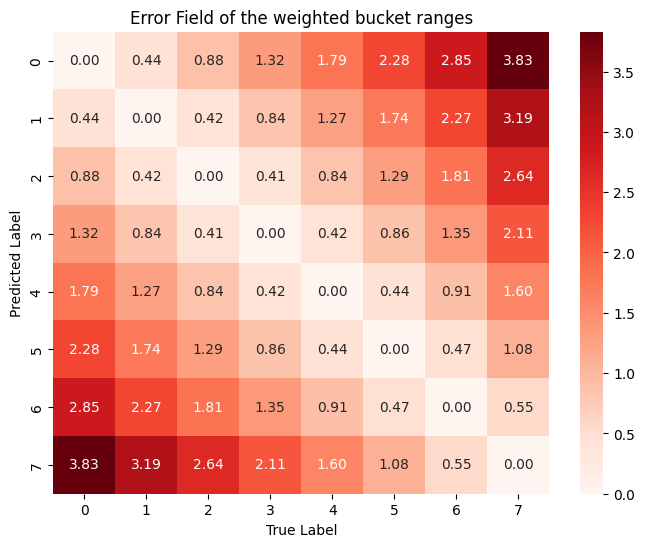

In [ ]:
def calculate_err_field(bucket_ranges:dict[int, float]):
    err_field = np.zeros((num_buckets, num_buckets))
    max_range = max(bucket_ranges.values()) 
    for i in range(num_buckets):
        for j in range(num_buckets):
            err_field[i][j] = get_penalty(i+1, j+1, bucket_ranges, 1.5, max_range)
    return err_field

err_field = calculate_err_field(normalized_bucket_ranges)

plt.figure(figsize=(8, 6))
sns.heatmap(err_field, annot=True, fmt=".2f", cmap="Reds", cbar=True)

plt.title("Error Field of the weighted bucket ranges")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()


In [ ]:
print(relaxed_accuracy_with_weighted_ranges(y_test, y_pred, normalized_bucket_ranges))